In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

## Linear regression

In [3]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

In [4]:
def add_regression_to_table(t, x, y):
    """ Returns a new table with 'Fitted value' and 'Residual' columns added """
    t_with_extra_cols = t.with_columns(
        'Fitted value', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    return t_with_extra_cols

## Properties of residuals

In [5]:
galton = Table.read_table('galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
)

heights = add_regression_to_table(
    heights, 'MidParent', 'Child'
)

In [6]:
heights

MidParent,Child,Fitted value,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


In [7]:
correlation(heights, 'MidParent', 'Child')

0.32094989606395924

In [8]:
#mean

In [9]:
np.round(correlation(heights, 'MidParent', 'Residual'))

-0.0

In [10]:
np.round(correlation(heights, 'Residual', 'Fitted value'))

-0.0

In [11]:
demographics_all = Table.read_table('district_demographics2016.csv')
demographics = demographics_all.drop(
    'State', 'District', 'Percent voting for Clinton')

demographics = add_regression_to_table(
    demographics, 'College%', 'Median Income'
)

In [12]:
np.round(correlation(demographics, 'College%', 'Median Income'), 6)

0.818465

In [13]:
np.round(correlation(demographics, 'Fitted value', 'Residual'), 6)

0.0

In [14]:
np.round(correlation(demographics, 'College%', 'Residual'), 6)

0.0

In [15]:
obs_height_sd = np.std(heights.column('Child'))
obs_height_sd

3.5773346010057634

## Correlation as a measure of clustering

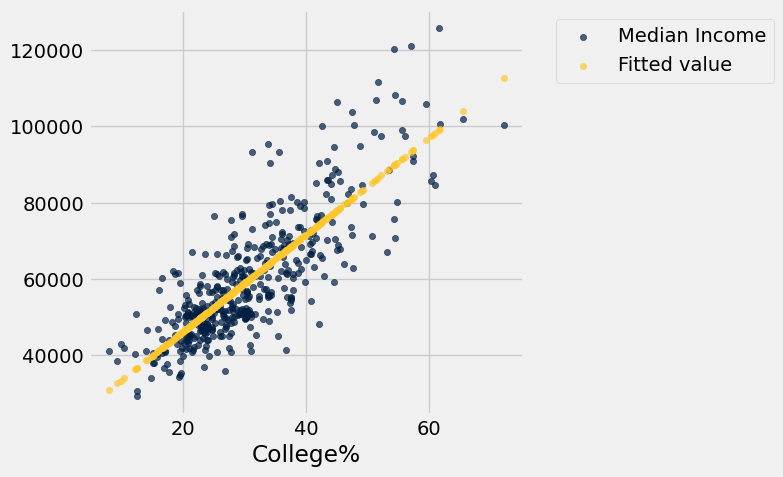

In [16]:
demographics.drop('Residual').scatter('College%')

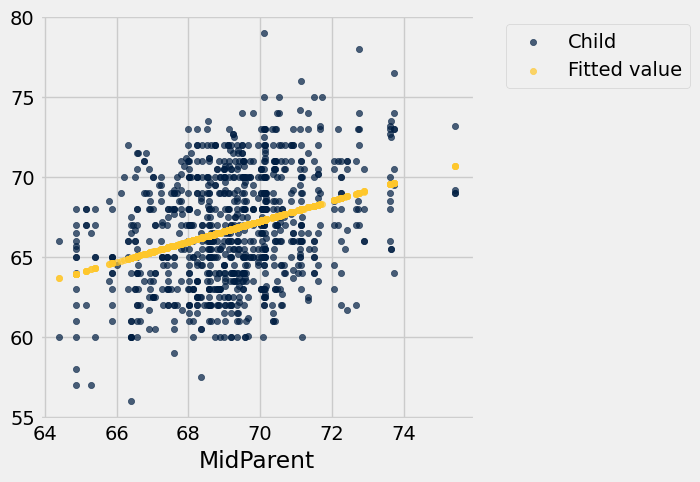

In [17]:
heights.drop('Residual').scatter('MidParent')

In [18]:
income_obs_sd = np.std(demographics.column('Median Income'))
income_obs_sd

16357.858546788269

In [19]:
income_pred_sd = np.std(demographics.column('Fitted value'))
income_pred_sd

13388.33226985783

In [20]:
income_pred_sd / income_obs_sd

0.81846485171413341

In [21]:
r_demographics = correlation(demographics, 'College%', 'Median Income')
r_demographics

0.81846485171413352

In [22]:
height_obs_sd = np.std(heights.column('Child'))
height_obs_sd

3.5773346010057634

In [23]:
height_pred_sd = np.std(heights.column('Fitted value'))
height_pred_sd

1.148145168378806

In [24]:
height_pred_sd / height_obs_sd

0.32094989606395957

In [25]:
r_heights = correlation(heights, 'MidParent', 'Child')
r_heights

0.32094989606395924

No matter what the shape of the scatter plot, the SD of the fitted values is a fraction of the SD of the observed values of $y$. The fraction is |r|.

$$
\frac{\mbox{SD of fitted values}}{\mbox{SD of observed values}} ~=~ |r| ~~~~~~~~~~ \mbox{That is,} ~~ \mbox{SD of fitted values} = |r|\cdot \mbox{SD of }y
$$

## Variance decomposition

In [26]:
height_residual_sd = np.std(heights.column('Residual'))
height_residual_sd / height_obs_sd

0.947096174744959

In [27]:
np.sqrt(1-r_heights**2)

0.94709617474495889

No matter what the shape of the scatter plot, the SD of the residuals is a fraction of the SD of the observed values of $y$. The fraction is  $\sqrt{1-r^2}$.

$$
\mbox{SD of residuals} ~=~ \sqrt{1 - r^2} \cdot \mbox{SD of }y
$$

### Some more examples: dugongs and hybrid cars

In [28]:
dugong = Table.read_table('dugong.csv')

In [29]:
np.std(dugong.column('Age')) ** 2

59.635802469135804

In [30]:
np.std(fitted_values(dugong, 'Length', 'Age')) ** 2

41.048211436935333

In [31]:
np.std(residuals(dugong, 'Length', 'Age')) ** 2

18.58759103220045

In [32]:
hybrid = Table.read_table('hybrid.csv')

In [33]:
np.std(residuals(hybrid, 'acceleration', 'mpg'))

9.4327368334302903

In [34]:
r_hybrid = correlation(hybrid, 'acceleration', 'mpg')
r_hybrid

-0.5060703843771186

In [35]:
np.sqrt(1 - r_hybrid**2)*np.std(hybrid.column('mpg'))

9.4327368334302903

## Regression Model ##

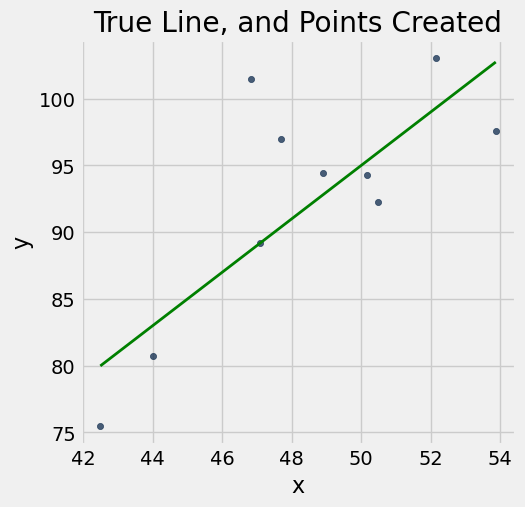

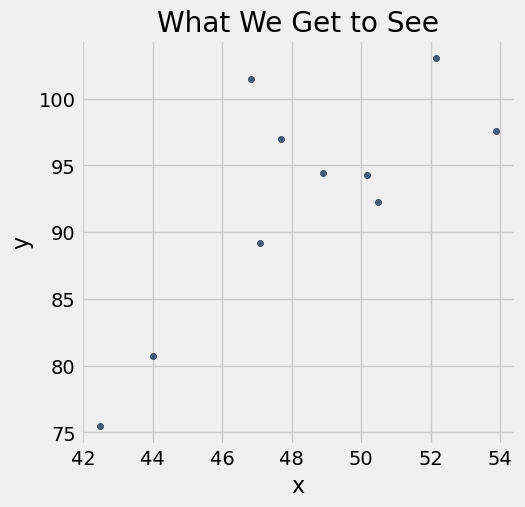

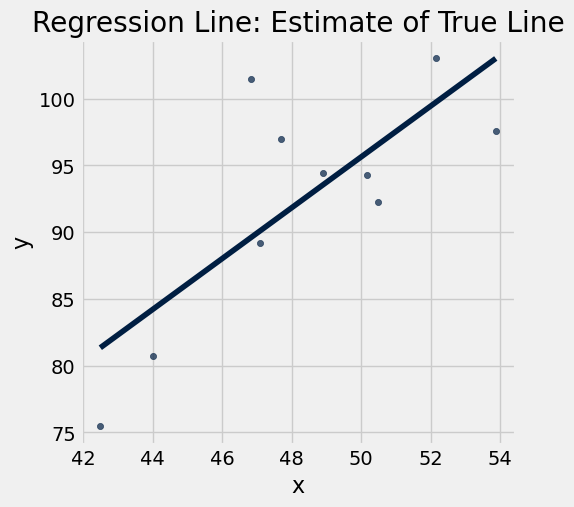

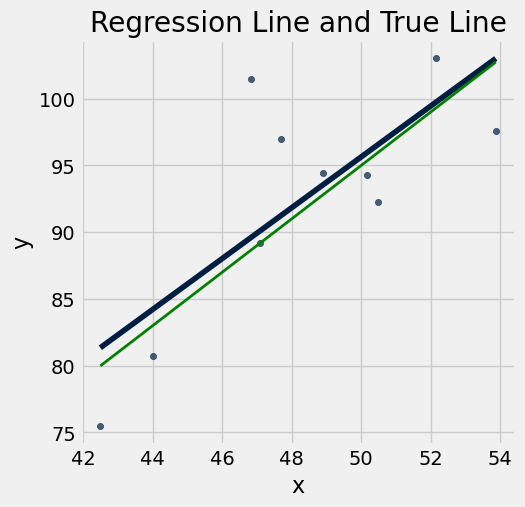

In [36]:
draw_and_compare(2, -5, 10)

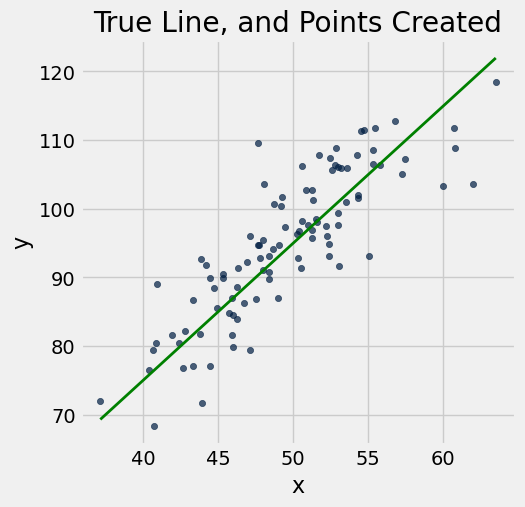

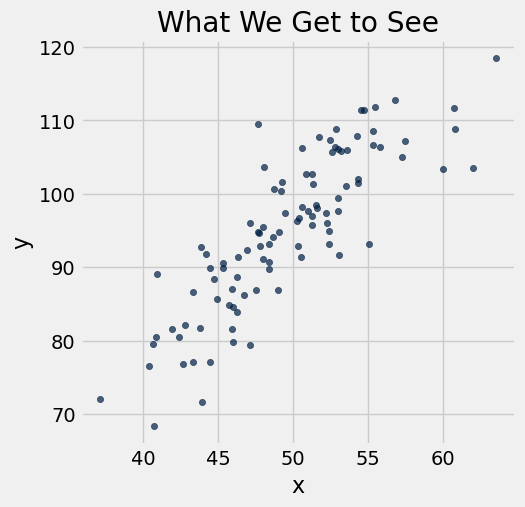

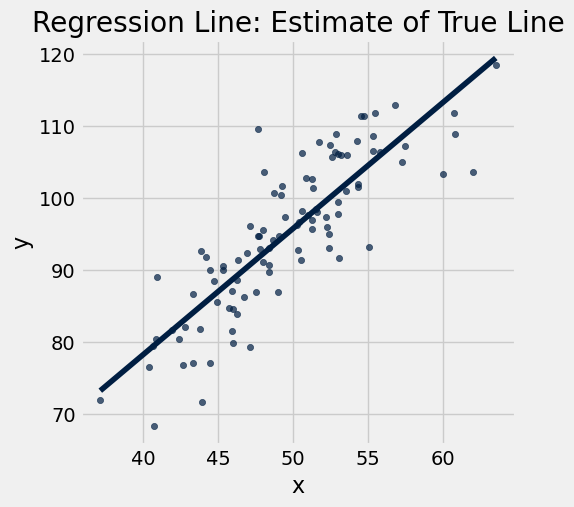

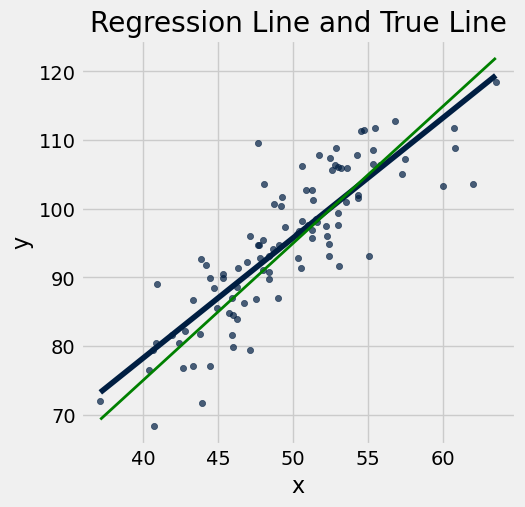

In [37]:
draw_and_compare(2, -5, 100)

## Prediction ##

In [38]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


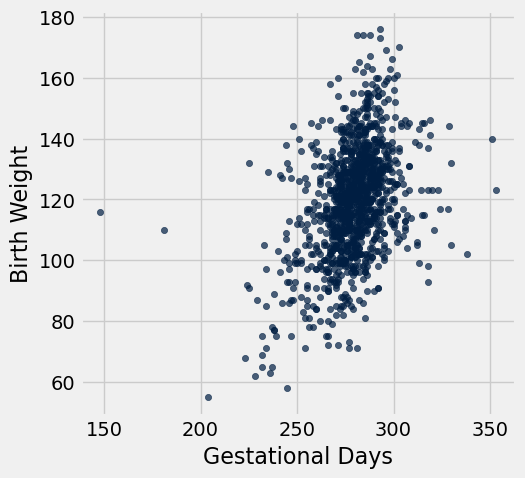

In [39]:
births.scatter('Gestational Days', 'Birth Weight')

In [40]:
births = births.where('Gestational Days', are.between(240, 320))

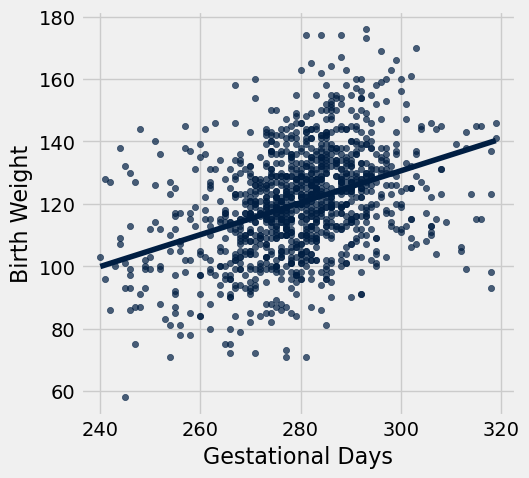

In [41]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [42]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [43]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.53859795467929

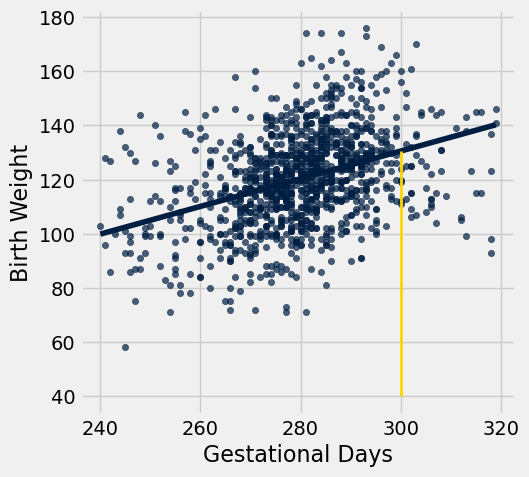

In [44]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='gold', lw=2);

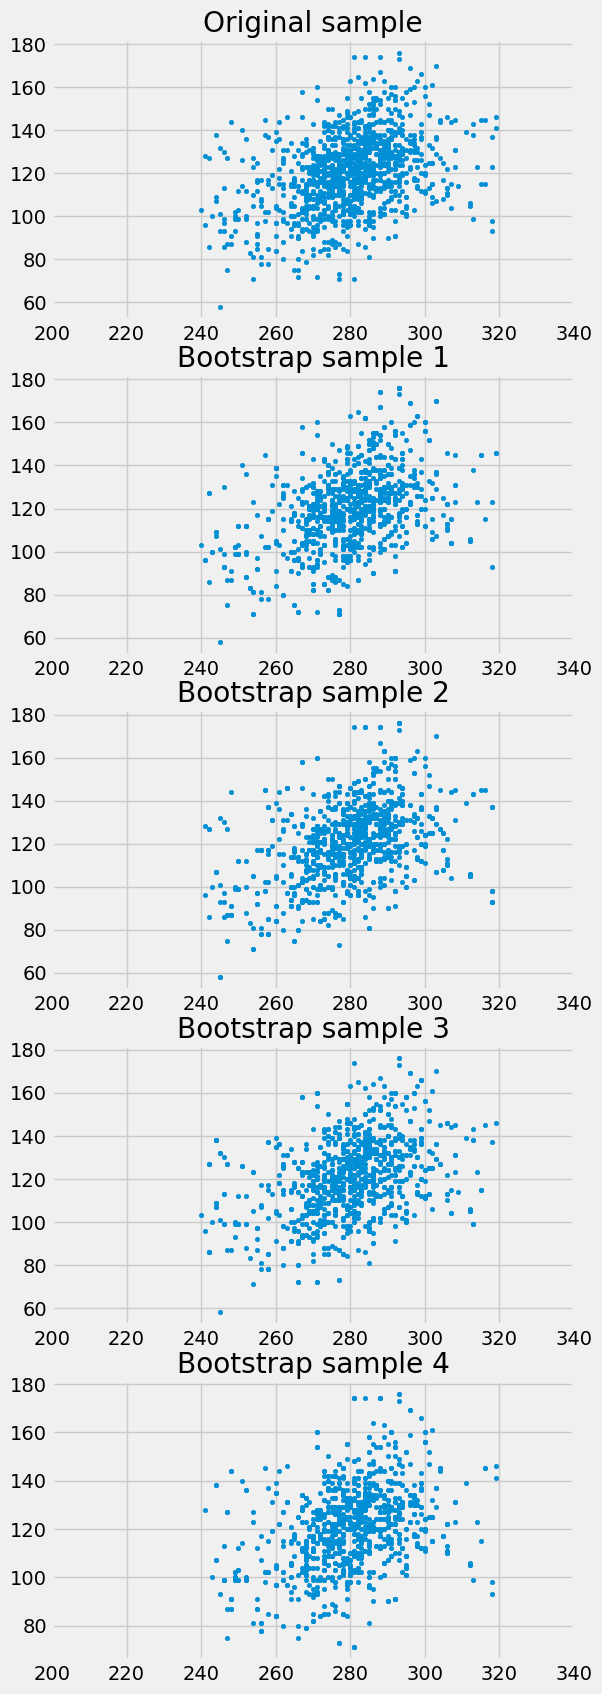

In [45]:
plots.figure(figsize=(6, 20))
plots.subplot(5, 1, 1)
plots.scatter(births[1], births[0], s=10)
plots.xlim([200, 340])
plots.title('Original sample')

for i in np.arange(1, 5, 1):
    plots.subplot(5,1,i+1)
    rep = births.sample()
    plots.scatter(rep[1], rep[0], s=10)
    plots.xlim([200, 340])
    plots.title('Bootstrap sample '+str(i))

Predicted y from bootstramp sample was 130.760556046
Predicted y from bootstramp sample was 129.437650808
Predicted y from bootstramp sample was 131.468530569
Predicted y from bootstramp sample was 131.473007051


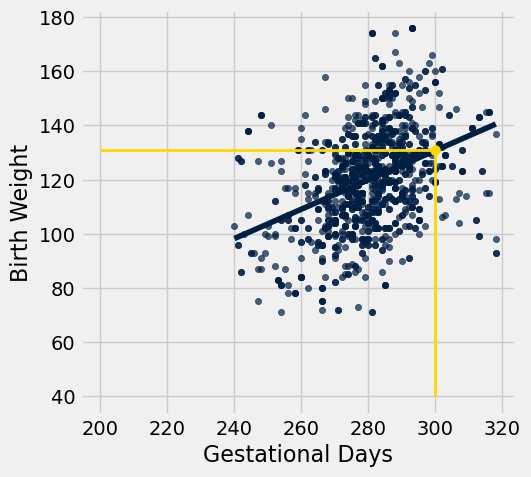

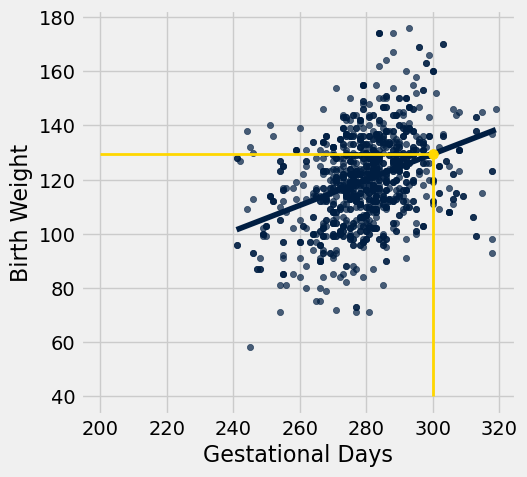

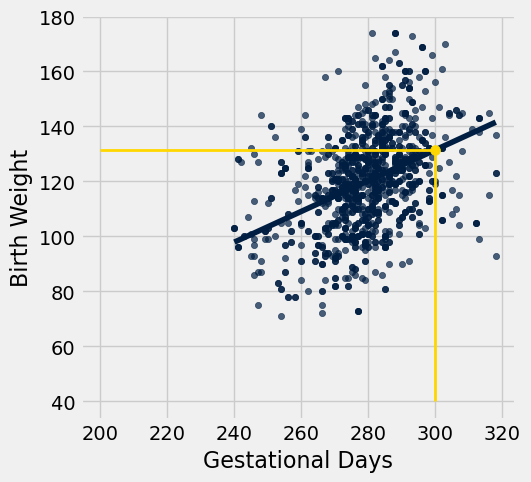

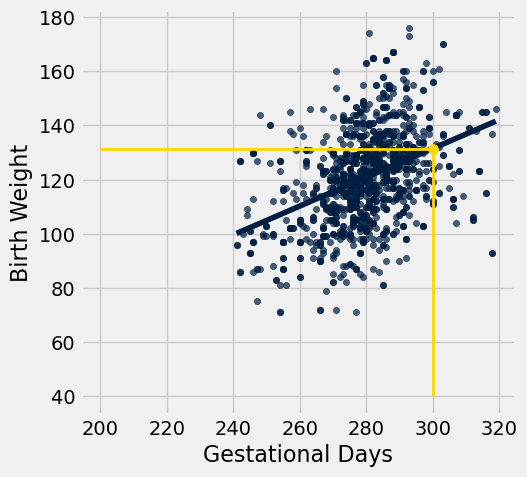

In [46]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [40, predicted_y], color='gold', lw=2);
    plots.plot([200, x], [predicted_y, predicted_y], color='gold', lw=2);

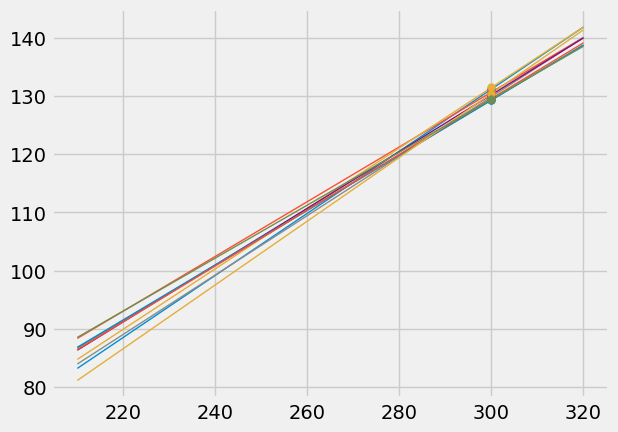

In [47]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

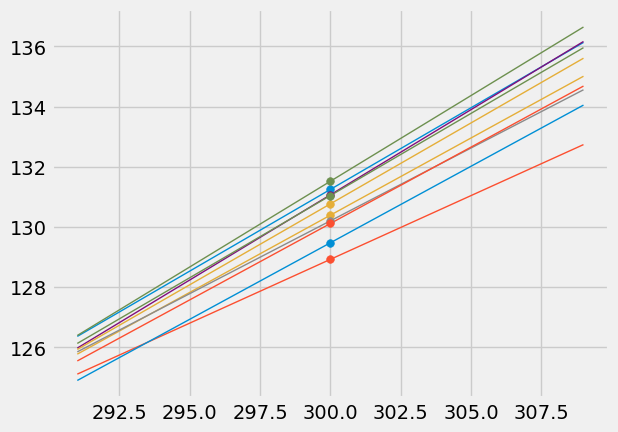

In [48]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## Confidence Interval for Prediction ##

In [49]:
def bootstrap_prediction(t, x, y, new_x, repetitions=1000):

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')') 

Approximate 95%-confidence interval for height of true line:
128.605267566 132.504123907 (width = 3.89885634079 )


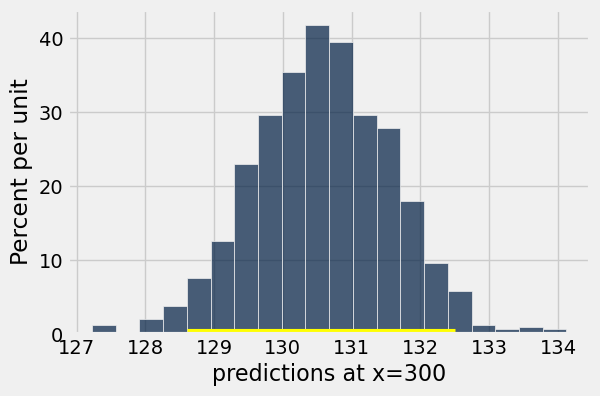

In [50]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

## Predictions at Different Values of X

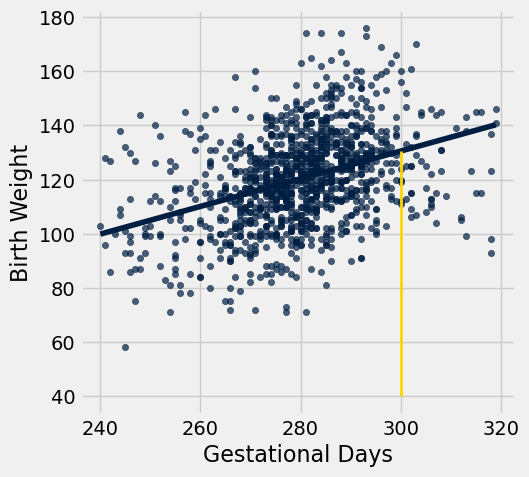

In [51]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='gold', lw=2);

Approximate 95%-confidence interval for height of true line:
78.5271400244 90.2992828198 (width = 11.7721427954 )


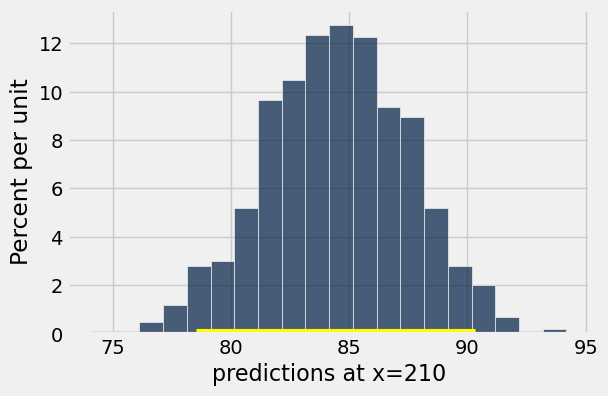

In [52]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 210)

Approximate 95%-confidence interval for height of true line:
119.363946484 121.243635009 (width = 1.8796885251 )


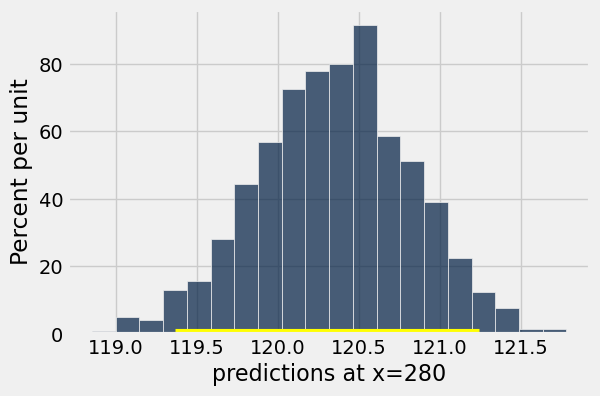

In [53]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

In [54]:
np.mean(births.column('Gestational Days'))

279.72080772607552

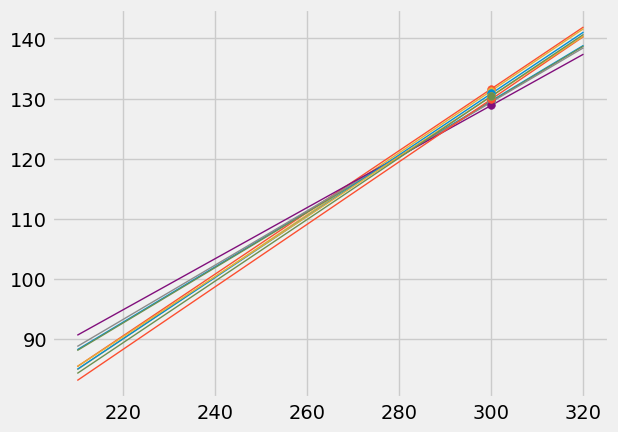

In [55]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## Inference for the Slope ##

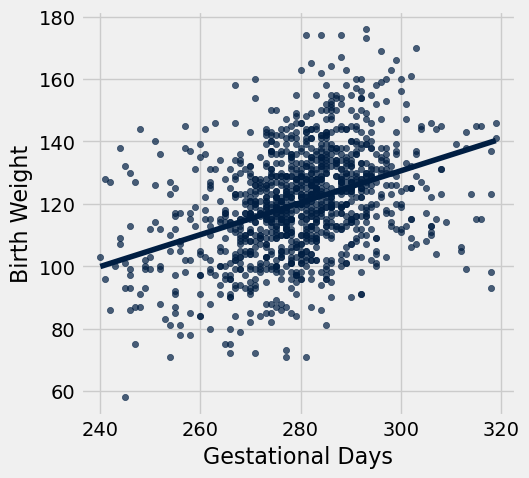

In [56]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [57]:
slope(births, 'Gestational Days', 'Birth Weight')

0.5110166711567975

In [58]:
def bootstrap_slope(t, x, y, repetitions=5000):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

Slope of regression line: 0.511016671157
Approximate 95%-confidence interval for the slope of the true line:
0.433305501116 to 0.597432305152


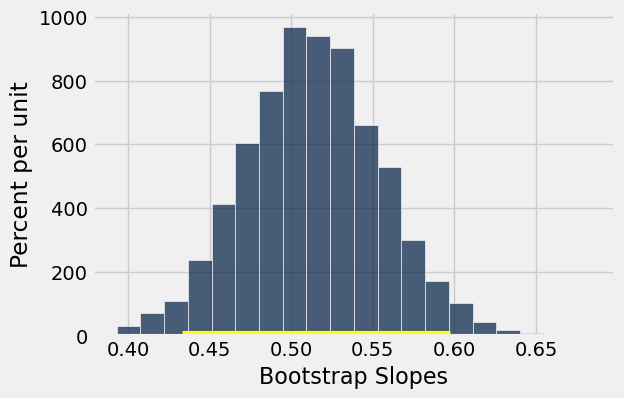

In [60]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight', 2500)

## Rain on the Regression Parade

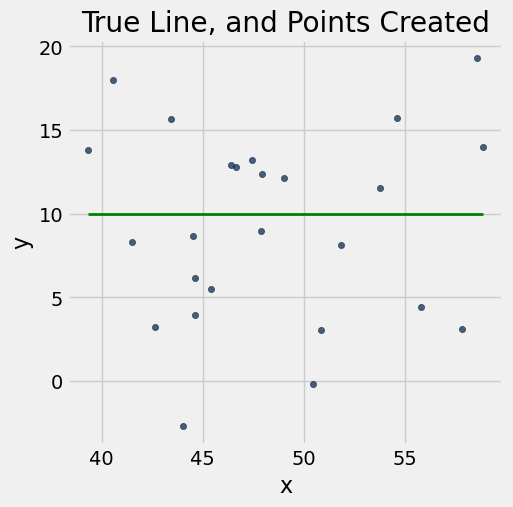

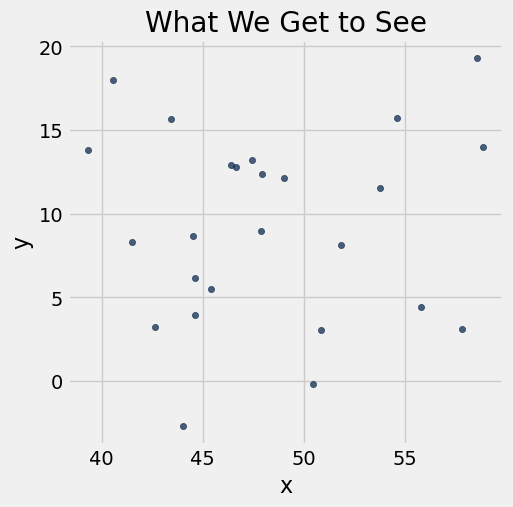

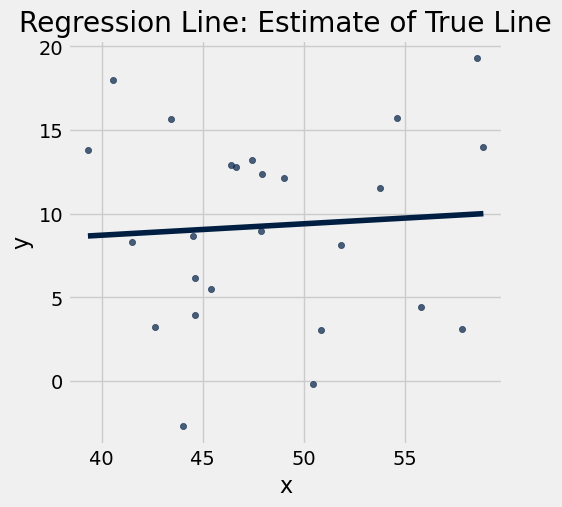

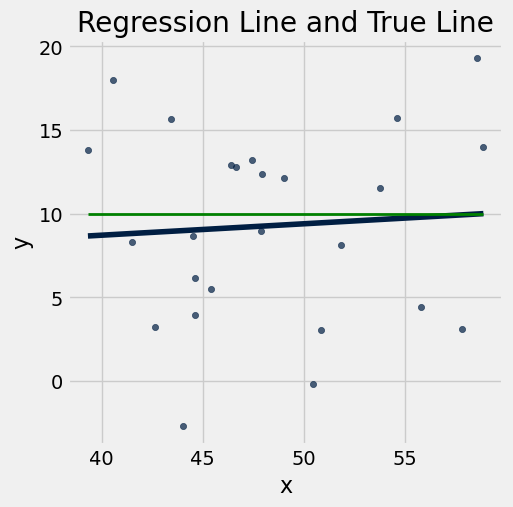

In [61]:
draw_and_compare(0, 10, 25)

**Null Hypothesis.** Slope of true line = 0.

**Alternative Hypothesis.** Slope of true line is not 0.

In [62]:
slope(births, 'Maternal Age', 'Birth Weight')

0.10714722656623907

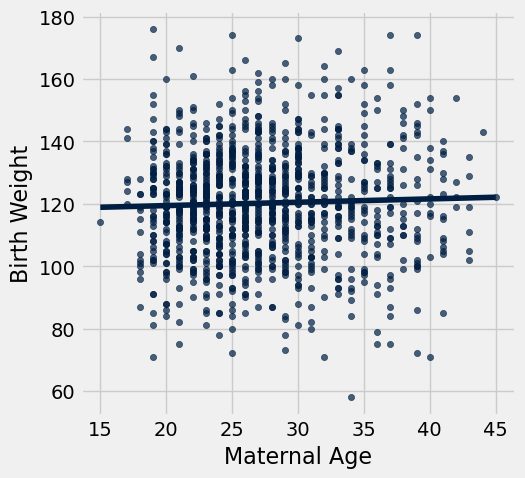

In [63]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

Slope of regression line: 0.107147226566
Approximate 95%-confidence interval for the slope of the true line:
-0.0748405010745 to 0.289281735408


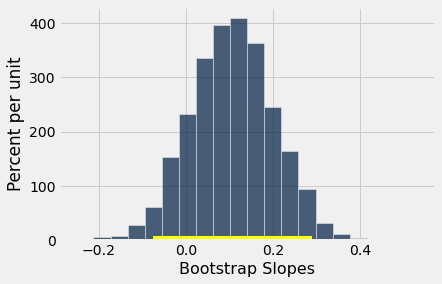

In [61]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight', 2500)